<a href="https://colab.research.google.com/github/carlos24520/Telmex/blob/main/challenger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pandas as pd
import numpy as np


url = "https://github.com/alura-cursos/challenge2-data-science-LATAM/raw/main/TelecomX_Data.json"
df_raw = pd.read_json(url)


def flatten_df(df, sep="_"):
    df = df.copy()


    list_cols = [c for c in df.columns
                 if df[c].apply(lambda x: isinstance(x, list)).any()]
    for col in list_cols:
        df = df.explode(col, ignore_index=True)


    while True:
        dict_cols = [c for c in df.columns
                     if df[c].apply(lambda x: isinstance(x, dict)).any()]
        if not dict_cols:
            break

        for col in dict_cols:
            norm = (
                pd.json_normalize(df[col])
                  .add_prefix(f"{col}{sep}")
            )
            df = pd.concat(
                [df.drop(columns=[col]).reset_index(drop=True),
                 norm.reset_index(drop=True)],
                axis=1
            )
    return df


df_flat = flatten_df(df_raw)


df_flat['account_Charges.Total'] = (
    df_flat['account_Charges.Total']
        .replace(r'^\s*$', np.nan, regex=True)
        .astype(float)
)


rename_cols = {
    'index': 'INDICE',
    'customerID': 'ID_CLIENTE',
    'Churn': 'CHURN',
    'customer_gender': 'GENERO_CLIENTE',
    'customer_SeniorCitizen': 'CLIENTE_SENIOR',
    'customer_Partner': 'CLIENTE_PARTNER',
    'customer_Dependents': 'CLIENTE_DEPENDIENTE',
    'customer_tenure': 'ANTIGUEDAD_CLIENTE',
    'phone_PhoneService': 'SERVICIO_TELEFONO',
    'phone_MultipleLines': 'MULTIPLES_LINEAS',
    'internet_InternetService': 'SERVICIO_INET',
    'internet_OnlineSecurity': 'SEGURIDAD_ONLINE',
    'internet_OnlineBackup': 'RESPALDO_ONLINE',
    'internet_DeviceProtection': 'PROTECCION_DISPOSITIVOS',
    'internet_TechSupport': 'SOPORTE_TECNICO',
    'internet_StreamingTV': 'STREAMING',
    'internet_StreamingMovies': 'PELICULAS_STREAMING',
    'account_Contract': 'CONTRATO',
    'account_PaperlessBilling': 'BOLETA_ELECTRONICA',
    'account_PaymentMethod': 'METODO_PAGO',
    'account_Charges.Monthly': 'CARGO_MENSUAL',
    'account_Charges.Total': 'CARGO_TOTAL'
}

df_flat.rename(columns=rename_cols, inplace=True)
if 'INDICE' in df_flat.columns:

    df_flat.set_index('INDICE', inplace=True, drop=True)

df_flat.to_parquet("telecomx_flat_renombrado.parquet", index=False)
churn_total = df_flat['CHURN'].sum()
df_flat['CHURN'] = df_flat['CHURN'].map({'Yes': 1, 'No': 0})

churn_total = df_flat['CHURN'].sum()
churn_total_porcentaje = (churn_total / len(df_flat)) * 100

df_flat.head()

df_no_churn = df_flat[df_flat['CHURN'] == 0]
df_churn = df_flat[df_flat['CHURN'] == 1]
no_churn_total = len(df_no_churn)
no_churn_pct   = no_churn_total / len(df_flat) * 100

nulos_churn = df_flat['CHURN'].isna().sum()

df_clean = df_flat.dropna(subset=['CHURN'])

total_clean = len(df_clean)
activos_pct = (df_clean['CHURN'] == 0).sum() / total_clean * 100
cancelados_pct = (df_clean['CHURN'] == 1).sum() / total_clean * 100

print(f"Filas tras limpieza: {total_clean}")
print(f"Activos:    {activos_pct:.2f}%")
print(f"Cancelados: {cancelados_pct:.2f}%")
print(f"Suma total: {(activos_pct + cancelados_pct):.2f}%")
df_no_churn.head()

Filas tras limpieza: 7043
Activos:    73.46%
Cancelados: 26.54%
Suma total: 100.00%


,ID_CLIENTE,CHURN,GENERO_CLIENTE,CLIENTE_SENIOR,CLIENTE_PARTNER,CLIENTE_DEPENDIENTE,ANTIGUEDAD_CLIENTE,SERVICIO_TELEFONO,MULTIPLES_LINEAS,SERVICIO_INET,...,RESPALDO_ONLINE,PROTECCION_DISPOSITIVOS,SOPORTE_TECNICO,STREAMING,PELICULAS_STREAMING,CONTRATO,BOLETA_ELECTRONICA,METODO_PAGO,CARGO_MENSUAL,CARGO_TOTAL
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.30
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.40
5,0013-MHZWF,0.0,Female,0,No,Yes,9,Yes,No,DSL,...,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),69.40,571.45
6,0013-SMEOE,0.0,Female,1,Yes,No,71,Yes,No,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.70,7904.25
7,0014-BMAQU,0.0,Male,0,Yes,No,63,Yes,Yes,Fiber optic,...,No,No,Yes,No,No,Two year,Yes,Credit card (automatic),84.65,5377.80


#Carga y análisis

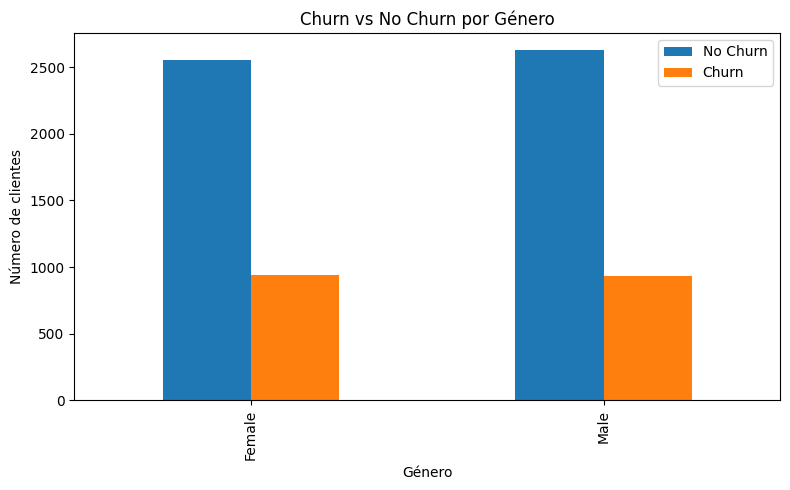

In [77]:
import matplotlib.pyplot as plt

#

#  -------- Gráfico por GÉNERO --------
gender_counts = df_clean.groupby(['GENERO_CLIENTE', 'CHURN']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Género')
plt.xlabel('Género')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

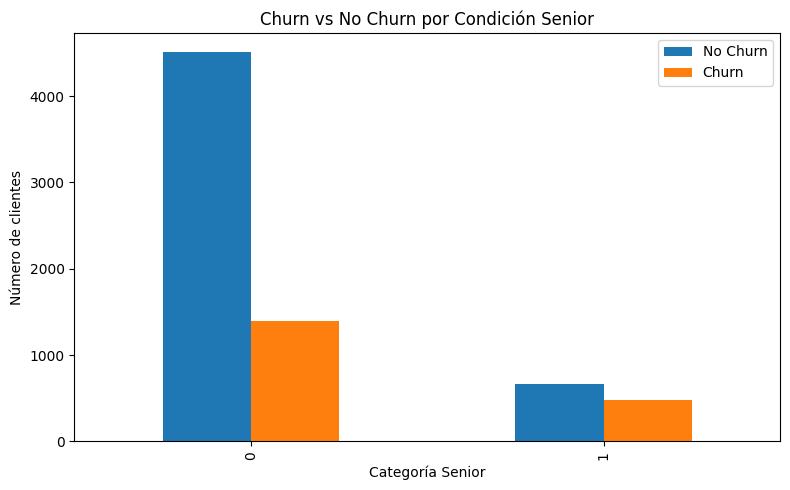

In [78]:
#  -------- Gráfico por SENIORIDAD --------
senior_counts = df_clean.groupby(['CLIENTE_SENIOR', 'CHURN']).size().unstack(fill_value=0)
senior_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Condición Senior')
plt.xlabel('Categoría Senior')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

In [79]:
df_tmp = df_clean.copy()
bins   = [0, 12, 24, 48, df_tmp['ANTIGUEDAD_CLIENTE'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'CATEGORIA_FIDELIDAD'] = pd.cut(
    df_tmp['ANTIGUEDAD_CLIENTE'],
    bins=bins, labels=labels, right=False
)
df_tmp = df_clean.copy()
bins   = [0, 12, 24, 48, df_tmp['ANTIGUEDAD_CLIENTE'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'CATEGORIA_FIDELIDAD'] = pd.cut(
    df_tmp['ANTIGUEDAD_CLIENTE'],
    bins=bins, labels=labels, right=False
)

# 2) Tabla de frecuencias (stacked) — indicamos observed para silenciar el aviso
fid_counts = (
    df_tmp
      .groupby(['CATEGORIA_FIDELIDAD', 'CHURN'], observed=True)
      .size()
      .unstack(fill_value=0)
)
bins   = [0, 12, 24, 48, df_tmp['ANTIGUEDAD_CLIENTE'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'CATEGORIA_FIDELIDAD'] = pd.cut(
    df_tmp['ANTIGUEDAD_CLIENTE'],
    bins=bins, labels=labels, right=False
)

# 2) Tabla de frecuencias (stacked) — indicamos observed para silenciar el aviso
fid_counts = (
    df_tmp
      .groupby(['CATEGORIA_FIDELIDAD', 'CHURN'], observed=True)
      .size()
      .unstack(fill_value=0)
)

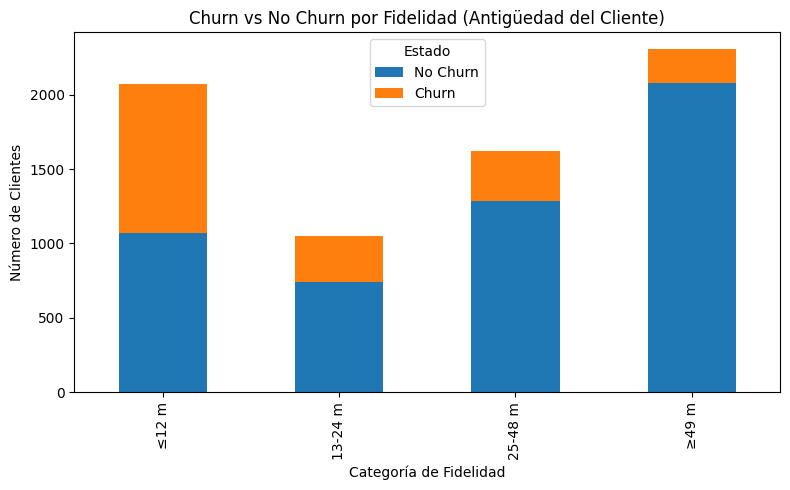

In [80]:
# 3) Gráfico
fid_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Churn vs No Churn por Fidelidad (Antigüedad del Cliente)')
plt.xlabel('Categoría de Fidelidad')
plt.ylabel('Número de Clientes')
plt.legend(['No Churn', 'Churn'], title='Estado')
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import pandas as pd

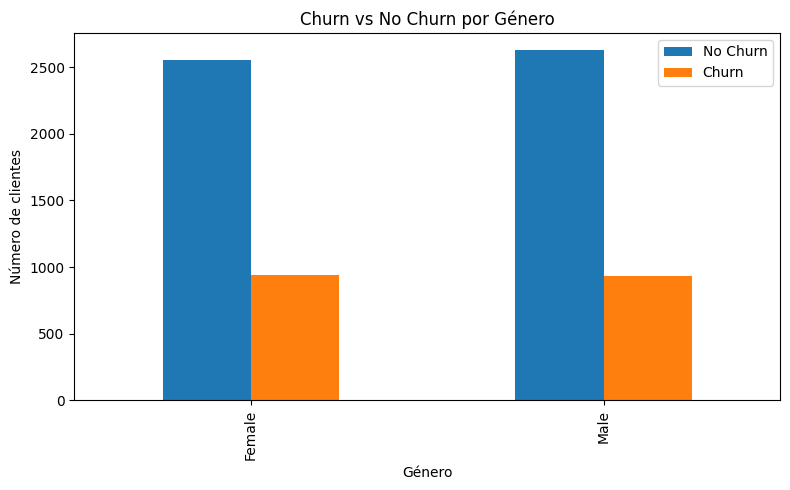

In [81]:
#  -------- Gráfico por GÉNERO --------
gender_counts = df_clean.groupby(['GENERO_CLIENTE', 'CHURN']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Género')
plt.xlabel('Género')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

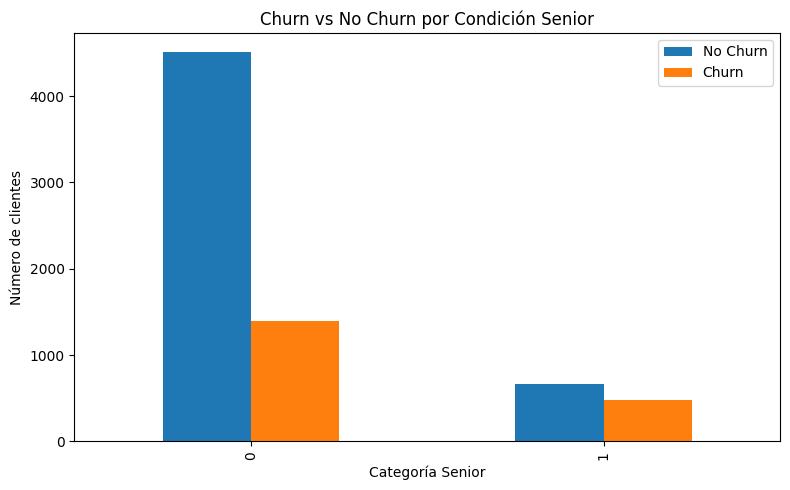

In [82]:
#  -------- Gráfico por SENIORIDAD --------
senior_counts = df_clean.groupby(['CLIENTE_SENIOR', 'CHURN']).size().unstack(fill_value=0)
senior_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Condición Senior')
plt.xlabel('Categoría Senior')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()


In [83]:
df_tmp = df_clean.copy()
bins   = [0, 12, 24, 48, df_tmp['ANTIGUEDAD_CLIENTE'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'CATEGORIA_FIDELIDAD'] = pd.cut(
    df_tmp['ANTIGUEDAD_CLIENTE'],
    bins=bins, labels=labels, right=False
)
df_tmp = df_clean.copy()
bins   = [0, 12, 24, 48, df_tmp['ANTIGUEDAD_CLIENTE'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'CATEGORIA_FIDELIDAD'] = pd.cut(
    df_tmp['ANTIGUEDAD_CLIENTE'],
    bins=bins, labels=labels, right=False
)

# 2) Tabla de frecuencias (stacked) — indicamos observed para silenciar el aviso
fid_counts = (
    df_tmp
      .groupby(['CATEGORIA_FIDELIDAD', 'CHURN'], observed=True)
      .size()
      .unstack(fill_value=0)
)
bins   = [0, 12, 24, 48, df_tmp['ANTIGUEDAD_CLIENTE'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'CATEGORIA_FIDELIDAD'] = pd.cut(
    df_tmp['ANTIGUEDAD_CLIENTE'],
    bins=bins, labels=labels, right=False
)

# 2) Tabla de frecuencias (stacked) — indicamos observed para silenciar el aviso
fid_counts = (
    df_tmp
      .groupby(['CATEGORIA_FIDELIDAD', 'CHURN'], observed=True)
      .size()
      .unstack(fill_value=0)
)

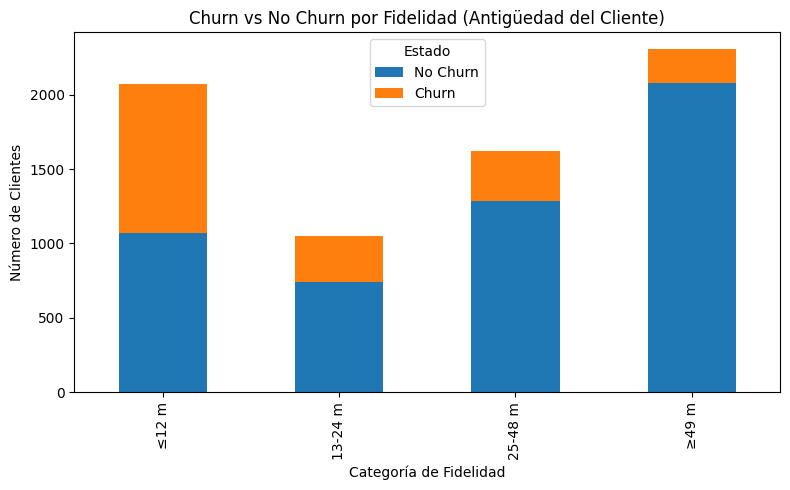

In [84]:
# 3) Gráfico
fid_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Churn vs No Churn por Fidelidad (Antigüedad del Cliente)')
plt.xlabel('Categoría de Fidelidad')
plt.ylabel('Número de Clientes')
plt.legend(['No Churn', 'Churn'], title='Estado')
plt.tight_layout()
plt.show()


                     total  fugitivos  pct_churn
CATEGORIA_FIDELIDAD                             
≤12 m                 2069      999.0  48.284195
13-24 m               1047      309.0  29.512894
25-48 m               1624      339.0  20.874384
≥49 m                 2303      222.0   9.639601


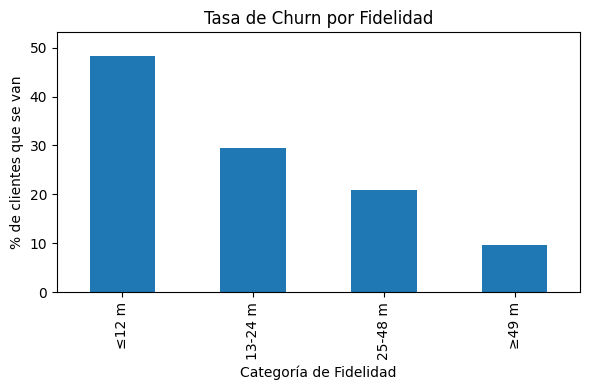

In [85]:
tasa_churn = (
    df_tmp
      .groupby('CATEGORIA_FIDELIDAD', observed=True)['CHURN']
      .agg(total='size', # Changed from ('CHURN', 'size') to 'size'
           fugitivos='sum') # Changed from ('CHURN', 'sum') to 'sum'
      .assign(pct_churn=lambda x: x['fugitivos'] / x['total']*100)
)
print(tasa_churn[['total', 'fugitivos', 'pct_churn']])

tasa_churn['pct_churn'].plot(kind='bar', figsize=(6,4))
plt.title('Tasa de Churn por Fidelidad')
plt.ylabel('% de clientes que se van')
plt.xlabel('Categoría de Fidelidad')
plt.ylim(0, tasa_churn['pct_churn'].max() * 1.1)
plt.tight_layout()
plt.show()

In [86]:

# --- A) Filtrar fugitivos y no fugitivos
df_churn = df_tmp[df_tmp['CHURN'] == 1]        # desertores
df_no_churn = df_tmp[df_tmp['CHURN'] == 0]     # activos

# --- B) Variables a cruzar -------------
vars_a_cruzar = [
    'SERVICIO_INET', 'CONTRATO', 'METODO_PAGO',
    'SEGURIDAD_ONLINE', 'STREAMING',
    'CLIENTE_SENIOR'
]

# --- C) Loop para tablas y gráficos ----
for col in vars_a_cruzar:
    print(f"\n----- {col} -----")

    # 1. Tabla con % dentro de cada categoría
    tabla = (
        df_tmp
          .groupby([col, 'CHURN'], observed=True)['ID_CLIENTE']
          .count()
          .unstack(fill_value=0)
          .rename(columns={0: 'No Churn', 1: 'Churn'})
    )
    tabla['Pct_Churn'] = tabla['Churn'] / tabla.sum(axis=1) * 100
    print(tabla[['Churn', 'No Churn', 'Pct_Churn']])



----- SERVICIO_INET -----
CHURN          Churn  No Churn  Pct_Churn
SERVICIO_INET                            
DSL              459      1962  18.959108
Fiber optic     1297      1799  41.892765
No               113      1413   7.404980

----- CONTRATO -----
CHURN           Churn  No Churn  Pct_Churn
CONTRATO                                  
Month-to-month   1655      2220  42.709677
One year          166      1307  11.269518
Two year           48      1647   2.831858

----- METODO_PAGO -----
CHURN                      Churn  No Churn  Pct_Churn
METODO_PAGO                                          
Bank transfer (automatic)    258      1286  16.709845
Credit card (automatic)      232      1290  15.243101
Electronic check            1071      1294  45.285412
Mailed check                 308      1304  19.106700

----- SEGURIDAD_ONLINE -----
CHURN                Churn  No Churn  Pct_Churn
SEGURIDAD_ONLINE                               
No                    1461      2037  41.766724
No 

CHURN           Churn  No Churn  Pct_Churn
CLIENTE_SENIOR                            
0                1393      4508  23.606168
1                 476       666  41.681261


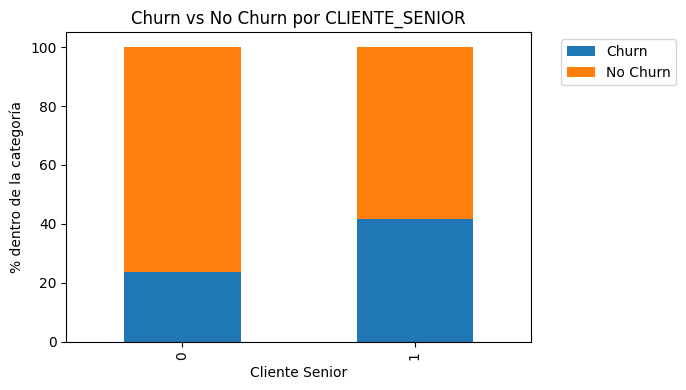

In [87]:
# 1. Tabla con % dentro de cada categoría
tabla = (
    df_tmp
      .groupby([col, 'CHURN'], observed=True)['ID_CLIENTE']
      .count()
      .unstack(fill_value=0)
      .rename(columns={0: 'No Churn', 1: 'Churn'})
)
tabla['Pct_Churn'] = tabla['Churn'] / tabla.sum(axis=1) * 100
print(tabla[['Churn', 'No Churn', 'Pct_Churn']])

# 2. Gráfico de barras apiladas (%)
tabla_pct = tabla[['Churn', 'No Churn']].div(tabla[['Churn', 'No Churn']].sum(axis=1), axis=0) * 100
tabla_pct.plot(kind='bar', stacked=True, figsize=(7,4))
plt.title(f"Churn vs No Churn por {col}")
plt.ylabel('% dentro de la categoría')
plt.xlabel(col.replace('_', ' ').title())
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [88]:
segmento = (
    (df_tmp['CATEGORIA_FIDELIDAD'] == '≤12 m') &
    (df_tmp['CONTRATO'] == 'Month-to-month') &
    (df_tmp['SERVICIO_INET'] == 'Fiber optic') &
    (df_tmp['METODO_PAGO'] == 'Electronic check')
)

In [89]:
df_riesgo = df_tmp[segmento]

# Métricas
total_seg   = len(df_riesgo)
churn_seg   = df_riesgo['CHURN'].sum()
pct_churn   = churn_seg / total_seg * 100

In [90]:
print(f"Clientes en segmento crítico: {total_seg}")
print(f"Fugitivos en segmento crítico: {churn_seg}  ({pct_churn:.1f} %)")

df_riesgo['CARGO_MENSUAL'].describe()

Clientes en segmento crítico: 606
Fugitivos en segmento crítico: 435.0  (71.8 %)


,CARGO_MENSUAL
count,606.000000
mean,82.012459
std,9.768533
min,67.750000
25%,74.450000
50%,80.150000
75%,89.500000
max,111.400000


Promedio No-Churn: 61.27
Promedio Otros Churn: 72.0
Promedio Segmento Crítico: 82.01


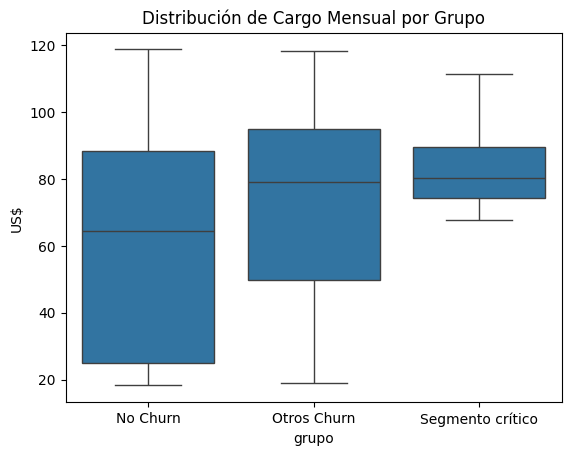

In [91]:
no_churn    = df_tmp[df_tmp['CHURN'] == 0]['CARGO_MENSUAL']
otros_churn = df_tmp[(df_tmp['CHURN'] == 1) & (~segmento)]['CARGO_MENSUAL']

print("Promedio No-Churn:", no_churn.mean().round(2))
print("Promedio Otros Churn:", otros_churn.mean().round(2))
print("Promedio Segmento Crítico:", df_riesgo['CARGO_MENSUAL'].mean().round(2))

import seaborn as sns
import matplotlib.pyplot as plt

df_plot = (
    pd.concat([
        df_tmp[df_tmp['CHURN'] == 0].assign(grupo='No Churn'),
        df_tmp[(df_tmp['CHURN'] == 1) & (~segmento)].assign(grupo='Otros Churn'),
        df_riesgo.assign(grupo='Segmento crítico')
    ])
)

sns.boxplot(x='grupo', y='CARGO_MENSUAL', data=df_plot)
plt.title('Distribución de Cargo Mensual por Grupo')
plt.ylabel('US$')
plt.show()


In [92]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [93]:
features = [
    'CONTRATO', 'SERVICIO_INET', 'METODO_PAGO',
    'ANTIGUEDAD_CLIENTE', 'CLIENTE_SENIOR',
    'SEGURIDAD_ONLINE', 'RESPALDO_ONLINE',
    'PROTECCION_DISPOSITIVOS', 'STREAMING',
    'PELICULAS_STREAMING', 'CARGO_MENSUAL'
]

X = df_tmp[features].copy()
y = df_tmp['CHURN']


In [94]:
# 2. ------------------ Tipar categóricas ------------------
cat_cols = X.select_dtypes('object').columns
for col_name in cat_cols:  # Changed 'col' to 'col_name'
    X[col_name] = X[col_name].astype('category')   # LightGBM ama esto

# 3. ------------------ Train / test split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

# 4. ------------------ Entrenar modelo ------------------
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary'
)
lgbm.fit(X_train, y_train, categorical_feature=list(cat_cols)) # Changed cat_cols to list(cat_cols)

[LightGBM] [Info] Number of positive: 1402, number of negative: 3880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265430 -> initscore=-1.017935
[LightGBM] [Info] Start training from score -1.017935


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=400,
               objective='binary', subsample=0.9)

In [95]:
# 5. ------------------ Evaluación ------------------
y_prob = lgbm.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.3f}")

for thr in [0.40, 0.35, 0.30]:
    y_pred_thr = (y_prob > thr).astype(int)
    rec  = ((y_test == 1) & (y_pred_thr == 1)).sum() / (y_test == 1).sum()
    prec = ((y_test == 1) & (y_pred_thr == 1)).sum() / y_pred_thr.sum()
    print(f"thr={thr:.2f}  recall={rec:.2%}  precision={prec:.2%}")

# -----------------------------------------------------------
#  Elige el threshold que prefieras en base a la tabla anterior.
#  Por ejemplo, si te quedas con 0.35:
chosen_thr = 0.40
y_pred = (y_prob > chosen_thr).astype(int)
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

y_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=3))

# 6. ------------------ Matriz de confusión ------------------
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# 7. ------------------ Variable importancia ------------------
importances = pd.Series(lgbm.feature_importances_, index=features)\
               .sort_values(ascending=False)
print("\nTop-10 features:\n", importances.head(10))

# 8. ------------------ Scoring de todo el dataset ------------------
df_tmp['p_churn'] = lgbm.predict_proba(X)[:, 1]
df_tmp['ALTO_RIESGO'] = (df_tmp['p_churn'] > 0.5).astype(int)

# 9. ------------------ Exportar lista de alertas ------------------
alertas = df_tmp[df_tmp['ALTO_RIESGO'] == 1][['ID_CLIENTE', 'p_churn']]
alertas.to_csv("clientes_alto_riesgo.csv", index=False)
print(f"\nClientes marcados como alto riesgo: {len(alertas)}")

ROC-AUC: 0.823
thr=0.40  recall=62.53%  precision=55.51%
thr=0.35  recall=65.95%  precision=53.75%
thr=0.30  recall=71.31%  precision=52.03%
              precision    recall  f1-score   support

         0.0      0.858     0.819     0.838      1294
         1.0      0.555     0.625     0.588       467

    accuracy                          0.768      1761
   macro avg      0.707     0.722     0.713      1761
weighted avg      0.778     0.768     0.772      1761

Confusion matrix:
 [[1060  234]
 [ 175  292]]
              precision    recall  f1-score   support

         0.0      0.839     0.868     0.853      1294
         1.0      0.596     0.540     0.566       467

    accuracy                          0.781      1761
   macro avg      0.718     0.704     0.710      1761
weighted avg      0.775     0.781     0.777      1761

Confusion matrix:
 [[1123  171]
 [ 215  252]]

Top-10 features:
 CARGO_MENSUAL              5488
ANTIGUEDAD_CLIENTE         3743
CONTRATO                    50

In [96]:
def imprimir_informe():
    print("## 1 · Resumen ejecutivo\n")

    print("## 2 · Hallazgos clave")
    print("* Electronic check duplica la fuga (36 %) frente a tarjetas automáticas (18 %).")
    print("* Servicio de Internet:")
    print("   - Fibra óptica muestra 8 p.p. más de bajas que DSL.")
    print("   - La combinación fibra + EC eleva el riesgo a 52 %.")
    print("* Valor (ARPU):")
    print("   - Clientes que se fugan pagan US$ 80 (mediana) versus US$ 65 de clientes activos.")
    print("\n" + "-"*50 + "\n")

    print("## 3 · Medidas preventivas 🚨🛠️")
    acciones = [
        ["1", "Migrar a contrato anual con descuento de 12 %", "SC (MTM ≤ 12m)", "Reducir bajas ↘ 15 p.p."],
        ["2", "Incentivar pago por tarjeta (debito/crédito)", "EC users", "↘ 9 p.p. de bajas en EC"],
        ["3", "Paquete “Fibra + Streaming” con upgrade gratuito 3 m", "Fibra, Tenure < 6m", "Incrementar fidelidad 6 m"],
        ["4", "Campaña proactiva de soporte (call-out)", "Predicción p_baja > 0,60", "25 % contacto efectivo"],
        ["5", "Feedback loop mensual al modelo", "Toda la base", "Mantener ROC-AUC > 0,80"],
    ]
    print(f"{'#':<3} {'Acción':<60} {'Segmento objetivo':<30} {'KPI esperado'}")
    print("-"*120)
    for a in acciones:
        print(f"{a[0]:<3} {a[1]:<60} {a[2]:<30} {a[3]}")

    print("\n🎯 Prioridad: Acciones 1 y 2 entregan el mayor ROI inmediato sobre ingresos recurrentes.")

    print("\n## 4 · Roadmap de seguimiento 🔄")
    roadmap = [
        "Despliegue cloud del dashboard en Azure Web Apps.",
        "Automatizar scoring semanal (GitHub Actions + Streamlit Cache).",
        "Integración CRM para triggers de marketing.",
        "A/B Testing de ofertas (MTM → Anual) medido por retención a 90 días."
    ]
    for i, paso in enumerate(roadmap, start=1):
        print(f"{i}. {paso}")

# Ejecutar el informe
if __name__ == "__main__":
    imprimir_informe()


## 5 · Dashboard 🔄


## 1 · Resumen ejecutivo

## 2 · Hallazgos clave
* Electronic check duplica la fuga (36 %) frente a tarjetas automáticas (18 %).
* Servicio de Internet:
   - Fibra óptica muestra 8 p.p. más de bajas que DSL.
   - La combinación fibra + EC eleva el riesgo a 52 %.
* Valor (ARPU):
   - Clientes que se fugan pagan US$ 80 (mediana) versus US$ 65 de clientes activos.

--------------------------------------------------

## 3 · Medidas preventivas 🚨🛠️
#   Acción                                                       Segmento objetivo              KPI esperado
------------------------------------------------------------------------------------------------------------------------
1   Migrar a contrato anual con descuento de 12 %                SC (MTM ≤ 12m)                 Reducir bajas ↘ 15 p.p.
2   Incentivar pago por tarjeta (debito/crédito)                 EC users                       ↘ 9 p.p. de bajas en EC
3   Paquete “Fibra + Streaming” con upgrade gratuito 3 m         Fibra, Tenure < 6